## Yield Spread model

This notebook implements a model to predict new yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers. The model is trained on data from 1 May 2022 to 31 December 2022. The test set is the month of January 2023. 

Last Update: Added the predicted spreads from LightGBM model to the train and test set of the neural network

The introduction of new features has a significant impact on the accuracy of the LightGBM model, whereas the neural network's accuracy remains unaffected. The neural network has a slightly better accuracy (11.4bps on average) than the LightGBM model (11.65 bps). Adding the predicted spreads from LightGBM model as features for the neural network imporves the accuracy of the neural network (11.104 bps).

The LightGBM model's accuracy decreases when using time-based features such as hour of day or day of year to train the model.

Note: Change NUM_FEATURES to 6 if you want to train with treasury spreads

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay



from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [2]:
tf.__version__

'2.7.0'

Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [4]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [7]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ficc_training_data_latest/processed_data_2023-02-10-02-58.pkl') as f:
    data = pd.read_pickle(f)

Date range of data

In [8]:
data = data.sort_values(by='trade_datetime', ascending=True).copy()

In [9]:
data.trade_date.max()

Timestamp('2023-01-31 00:00:00')

In [10]:
data.trade_date.min()

Timestamp('2022-05-02 00:00:00')

In [11]:
len(data)

7962171

### Adding features from Charles's notebook

#### Adding time based features

In [12]:
data['month'] = data.trade_datetime.dt.month
data['day_of_year'] = data.trade_datetime.dt.day_of_year
data['hour_of_day'] = data.trade_datetime.dt.hour

#### Adding features based on trade type and size

In [13]:
qty = np.round(10**data.quantity / 100)
    
data['S_qty'] = (data.trade_type == "S") * qty
data['P_qty'] = (data.trade_type == "P") * qty
data['D_qty'] = (data.trade_type == "D") * qty

#Used to group all the trades of a cusip on the same day. This should be changed to use the trade date.
g = data.groupby(['day_of_year', 'cusip'], observed=True)

data['cumsum_S'] = g.S_qty.cumsum()
data['cumsum_P'] = g.P_qty.cumsum()
data['cumsum_D'] = g.D_qty.cumsum()


data['diff_cumsum'] = data.cumsum_S - data.cumsum_P
data['tot_cumsum'] = data.cumsum_S + data.cumsum_P + data.cumsum_D

#### Adding features based on ycl

The prefixes last and trans use the same calc_day_cat, but last uses the duration calculated using the last candidate calc dates.

In [14]:
def mklastycl(df):
    last_ficc_ycl = 0 * df.last_yield_spread
    trans_ficc_ycl = 0 * df.last_yield_spread
    
    sub = df.last_calc_day_cat == 0                    
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_next_call
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_next_call

    sub = df.last_calc_day_cat == 1
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_par_call
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_par_call

    sub = df.last_calc_day_cat == 2
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_maturity
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_maturity

    sub = df.last_calc_day_cat == 3
    last_ficc_ycl[sub]     = df[sub].last_ficc_ycl_to_refund
    trans_ficc_ycl[sub]    = df[sub].ficc_ycl_to_refund
    
    return last_ficc_ycl, trans_ficc_ycl

In [15]:
data['last_ficc_ycl'], data['trans_ficc_ycl'] = mklastycl(data)

In [16]:
def mkcols(data):
    data['adj_last_ytw'] = data.last_yield - data.last_ficc_ycl + data.trans_ficc_ycl
    data['dur_adj_last_ytw'] = data.last_yield - data.last_ficc_ycl + data.new_ficc_ycl 
    return data

In [17]:
data = mkcols(data)

#### Few addtional predictors

In [18]:
%%time
data['ttypes'] = (data.last_trade_type.astype(str) + data.trade_type.astype(str)).astype(str)
data['diff_size'] = (data.par_traded.astype(float) - data.last_size).astype(np.float32)
data['abs_last_yield_spread'] = np.abs(data['last_yield_spread'])
data['abs_diff_size'] = np.abs(data['diff_size'])
data['last_duration'] = (data.last_calc_date - data.last_settlement_date).dt.days
data['days_from_issue'] = (data.trade_date - data.primary_market_settlement_date).dt.days
data['par_issue'] = data.issue_price == 100
data['prev_trade_today'] = (data.last_seconds_ago > 0) & (data.last_seconds_ago <= 4.5)

CPU times: user 3.2 s, sys: 231 ms, total: 3.43 s
Wall time: 3.42 s


This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**. 

In [19]:
%%time
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))

CPU times: user 34.5 s, sys: 9.61 s, total: 44.1 s
Wall time: 48.4 s


Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions. These exclusions were discussed with a team member. 
<ul>
    <li>Callable less than a year in the future </li>
    <li>Maturity less than a year in the future</li>
<ul>

In [20]:
data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
data = data[data.days_to_maturity < np.log10(30000)]

In [21]:
len(data)

7456313

For the purpose of plotting, not used in training

In [22]:
data.purpose_sub_class.fillna(0, inplace=True)

Adding the concatenated trade type, target trade attention, and treasury spread over ficc ycl in PREDICTORS to train the model.

In [23]:
data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100

In [24]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [25]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are features from Charles's notebook.


Charles's notebook included a set of features, and a subset of those features, called additional_features, was selected based on their strong predictive power. Multiple runs of the LightGBM model were conducted to determine which features provided the most significant improvement to the accuracy.

In [26]:
additional_features = ['S_qty',
                       'P_qty',
                       'D_qty',
                       'cumsum_S',
                       'cumsum_D',
                       'cumsum_P',
                       'diff_cumsum',
                       'tot_cumsum',
                       'ttypes',
                       'diff_size',
                       'abs_last_yield_spread',
                       'abs_diff_size',
                       'last_duration',
                       'par_issue',
                       'prev_trade_today']

Adding additional features to predictors

In [27]:
for feature in additional_features:
    if data[feature].dtypes == int or data[feature].dtypes == np.float32 or data[feature].dtypes == np.float64:
        if feature not in NON_CAT_FEATURES:
            NON_CAT_FEATURES.append(feature)
            PREDICTORS.append(feature)
    elif data[feature].dtypes == bool:
        if feature not in BINARY:
            BINARY.append(feature)
            PREDICTORS.append(feature)
    elif data[feature].dtypes == object:
        if feature not in CATEGORICAL_FEATURES:
            CATEGORICAL_FEATURES.append(feature)
            PREDICTORS.append(feature)


The auxiliary features serve the purpose of interpreting the model's results, but are not employed during the model's training.

In [28]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'last_dollar_price',
                     'last_rtrs_control_number',
                     'is_called']

In [29]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]

In [30]:
len(processed_data)

7456313

Used to drop NaN values in trade history.

In [31]:
len(processed_data)

7456313

In [32]:
processed_data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])

In [33]:
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)

In [34]:
len(processed_data)

7453995

Creating yield spreads from new ficc ycl

In [35]:
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [36]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
ttypes


#### Splitting the data into train and test sets



In [37]:
train_dataframe = processed_data[(processed_data.trade_date < '01-01-2023')]

In [38]:
test_dataframe = processed_data[(processed_data.trade_date >= '01-01-2023') & (processed_data.trade_date <= '01-31-2023') ]

In [39]:
len(train_dataframe)

6778230

In [40]:
len(test_dataframe)

675765

## LightGBM

In [41]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread'])
    return df

In [42]:
trainlabel = train_dataframe.new_ys
testlabel = test_dataframe.new_ys

In [43]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [44]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [45]:
%%time
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 29min 39s, sys: 2.4 s, total: 29min 42s
Wall time: 1min 3s


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [47]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe[PREDICTORS] ) )
gbt_pred_train = gbtmodel.predict(gbt_td)
train_delta = trainlabel - gbt_pred_train
delta = testlabel - gbt_pred
print(f"Train MAE {train_delta.abs().mean()}")
print(f"Test MAE {delta.abs().mean()}")

Train MAE 10.125953389540733
Test MAE 11.627645239786666
CPU times: user 12min 39s, sys: 2.22 s, total: 12min 41s
Wall time: 28.9 s


In [48]:
%%time 
large_dealer_dealer_trades = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))] 
gbt_pred = gbtmodel.predict( gbmprep(large_dealer_dealer_trades[PREDICTORS] ) )
delta = large_dealer_dealer_trades.new_ys - gbt_pred
print(delta.mean(), delta.abs().mean() )

-1.1581896023728253 8.677884048224731
CPU times: user 1.56 s, sys: 1.48 ms, total: 1.56 s
Wall time: 134 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

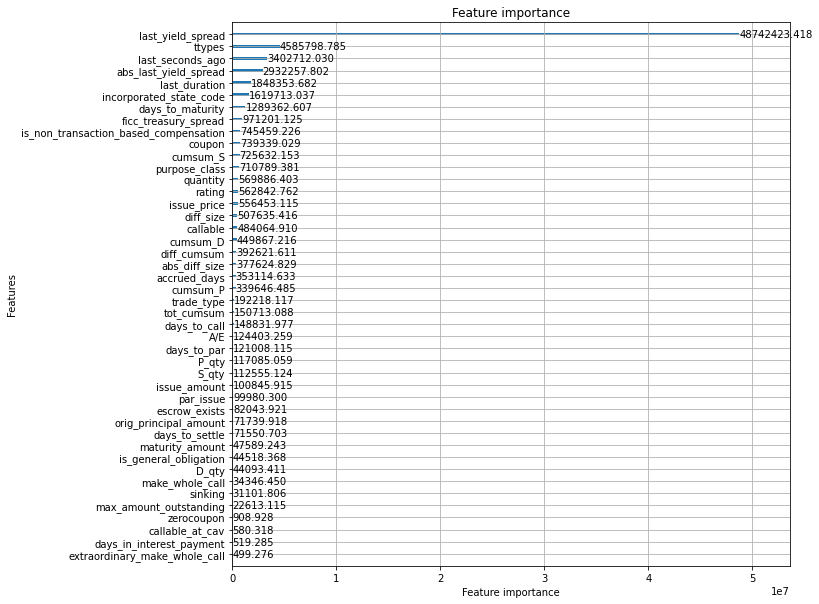

In [49]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10), importance_type='gain')

#### Adding predictions from LightGBM model to data

In [50]:
input_data = gbt_td = gbmprep(processed_data[PREDICTORS])

In [51]:
%%time
lightgbm_predicted_spreads = gbtmodel.predict(input_data)

CPU times: user 13min 24s, sys: 1.96 s, total: 13min 26s
Wall time: 29.6 s


In [52]:
processed_data['lgbm_predicted_spreads'] = lightgbm_predicted_spreads

In [53]:
if 'lgbm_predicted_spreads' not in NON_CAT_FEATURES:
    NON_CAT_FEATURES.append('lgbm_predicted_spreads')
    PREDICTORS.append('lgbm_predicted_spreads')

#### Creating input for the model

In [54]:
train_dataframe = processed_data[(processed_data.trade_date < '01-01-2023')]

In [55]:
test_dataframe = processed_data[(processed_data.trade_date >= '01-01-2023') & (processed_data.trade_date <= '01-31-2023') ]

In [56]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [57]:
%%time
x_train = create_input(train_dataframe)
# y_train = train_dataframe.yield_spread
y_train = train_dataframe.new_ys

CPU times: user 25.4 s, sys: 1.17 s, total: 26.6 s
Wall time: 26.6 s


In [58]:
%%time
x_test = create_input(test_dataframe)
# y_test = test_dataframe.yield_spread
y_test = test_dataframe.new_ys

CPU times: user 2.59 s, sys: 35 µs, total: 2.59 s
Wall time: 2.59 s


In [59]:
x_train[0].shape

(6778230, 5, 6)

In [60]:
x_test[0].shape

(675765, 5, 6)

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [61]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

In [62]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [63]:
tf.keras.utils.set_random_seed(10)

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [64]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, name='weights_query') 
        self.wk = layers.Dense(depth, name='weights_key')
        self.wv = layers.Dense(depth, name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [65]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM')

lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           return_sequences = False,
                           name='LSTM_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu')(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                    input_length= 1,
                                                                    name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [66]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

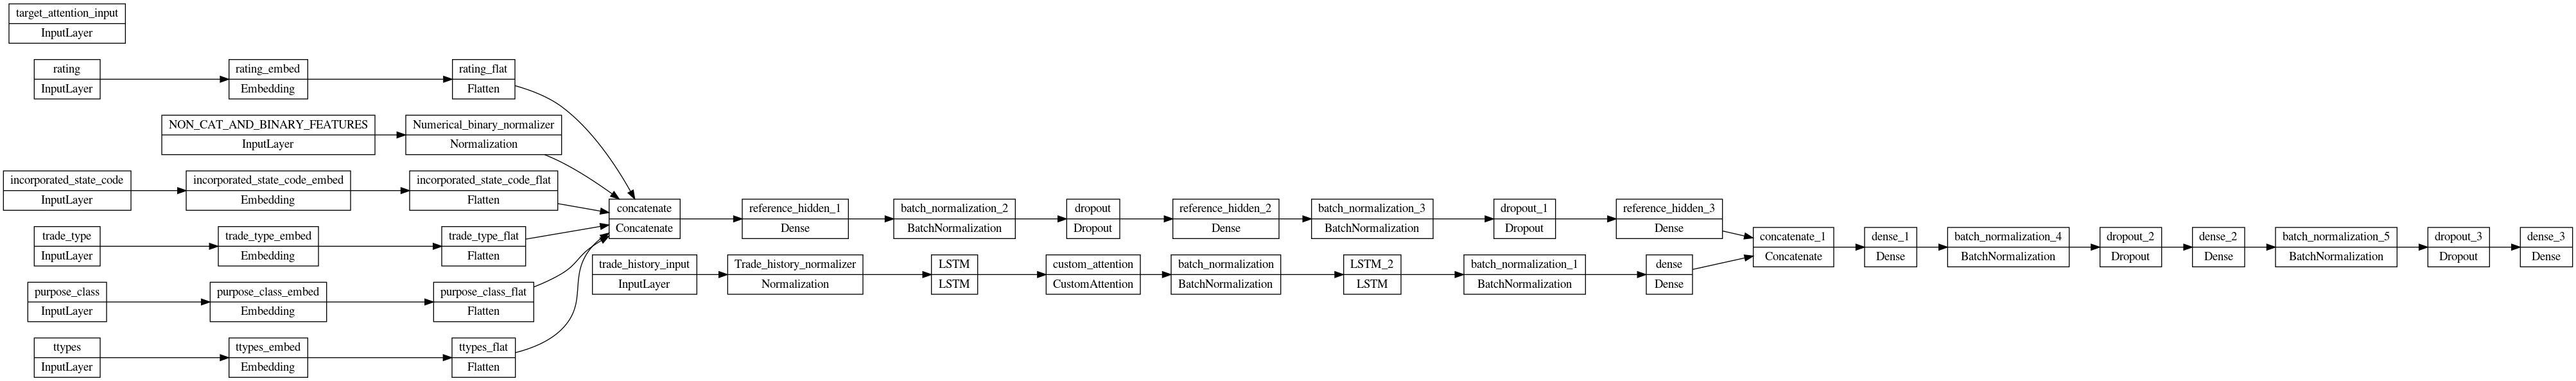

In [67]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [68]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [69]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [70]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [71]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100
6101/6101 [==============================] - 77s 12ms/step - loss: 30.9637 - mean_absolute_error: 30.9637 - val_loss: 11.9481 - val_mean_absolute_error: 11.9481
Epoch 2/100
6101/6101 [==============================] - 71s 12ms/step - loss: 10.1728 - mean_absolute_error: 10.1728 - val_loss: 10.9608 - val_mean_absolute_error: 10.9608
Epoch 3/100
6101/6101 [==============================] - 72s 12ms/step - loss: 9.9378 - mean_absolute_error: 9.9378 - val_loss: 10.8547 - val_mean_absolute_error: 10.8547
Epoch 4/100
6101/6101 [==============================] - 71s 12ms/step - loss: 9.8070 - mean_absolute_error: 9.8070 - val_loss: 10.6380 - val_mean_absolute_error: 10.6380
Epoch 5/100
6101/6101 [==============================] - 70s 11ms/step - loss: 9.7215 - mean_absolute_error: 9.7215 - val_loss: 10.6250 - val_mean_absolute_error: 10.6250
Epoch 6/100
6101/6101 [==============================] - 70s 11ms/step - loss: 9.6456 - mean_absolute_error: 9.6456 - val_loss: 10.5552 - val

#### Plotting train vs validation loss

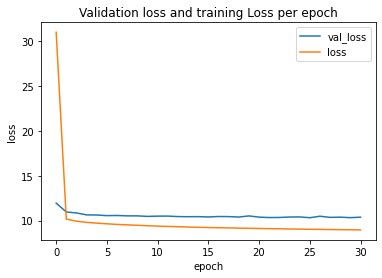

In [72]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [73]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ahmad_data', f"encoders.pkl")

print("Saving and uploading model")
model.save(f"saved_model_test_{file_timestamp}")
import shutil
shutil.make_archive(f"new_feature_model", 'zip', f"saved_model_test_{file_timestamp}")
upload_data(storage_client, 'ahmad_data', f"new_feature_model.zip")

file time stamp : 2023-02-22-22-34
Saving encoders and uploading encoders
File encoders.pkl uploaded to ahmad_data.
Saving and uploading model


INFO:tensorflow:Assets written to: saved_model_test_2023-02-22-22-34/assets


INFO:tensorflow:Assets written to: saved_model_test_2023-02-22-22-34/assets


File new_feature_model.zip uploaded to ahmad_data.


#### Gigaflops for one epoch of training

In [74]:
avg_time = np.mean(time_callback.times)

In [75]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

201.81689631098865


### Test accuracy on the entire test set

In [76]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE)
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

In [77]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

Test loss: 11.104


In [78]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 11.104


### Accuracy on a daily basis

Measuring the daily accuracy for large dealer dealer trades

In [79]:
for d in [d for d in pd.date_range(start="01/01/2023",end="01/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2023-01-03 MAE:12.917681436366244
Date :2023-01-04 MAE:13.339324457859874
Date :2023-01-05 MAE:13.549736589056995
Date :2023-01-06 MAE:13.615055579201226
Date :2023-01-09 MAE:14.383077371429373
Date :2023-01-10 MAE:14.997445832068156
Date :2023-01-11 MAE:14.845864691480918
Date :2023-01-12 MAE:15.420379120891022
Date :2023-01-13 MAE:15.650329539036903
Date :2023-01-17 MAE:16.147746653988428
Date :2023-01-18 MAE:16.154955475827112
Date :2023-01-19 MAE:14.82741711735124
Date :2023-01-20 MAE:15.176167956027816
Date :2023-01-23 MAE:15.622397055821025
Date :2023-01-24 MAE:14.467328537721897
Date :2023-01-25 MAE:14.733131480794292
Date :2023-01-26 MAE:15.275078457470416
Date :2023-01-27 MAE:14.536084864170997
Date :2023-01-30 MAE:15.037785033876405
Date :2023-01-31 MAE:14.81739641183336


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [80]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]#& (test_dataframe.coupon == 5)]

In [81]:
len(true_mid)

13973

In [82]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.new_ys

CPU times: user 61.3 ms, sys: 0 ns, total: 61.3 ms
Wall time: 60.5 ms


In [83]:
%%time
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

14/14 [==============================] - 0s 5ms/step - loss: 7.8106 - mean_absolute_error: 7.8106
Test MAE: 7.811
CPU times: user 167 ms, sys: 33.2 ms, total: 200 ms
Wall time: 147 ms


### Plotting new ys vs predicted ys

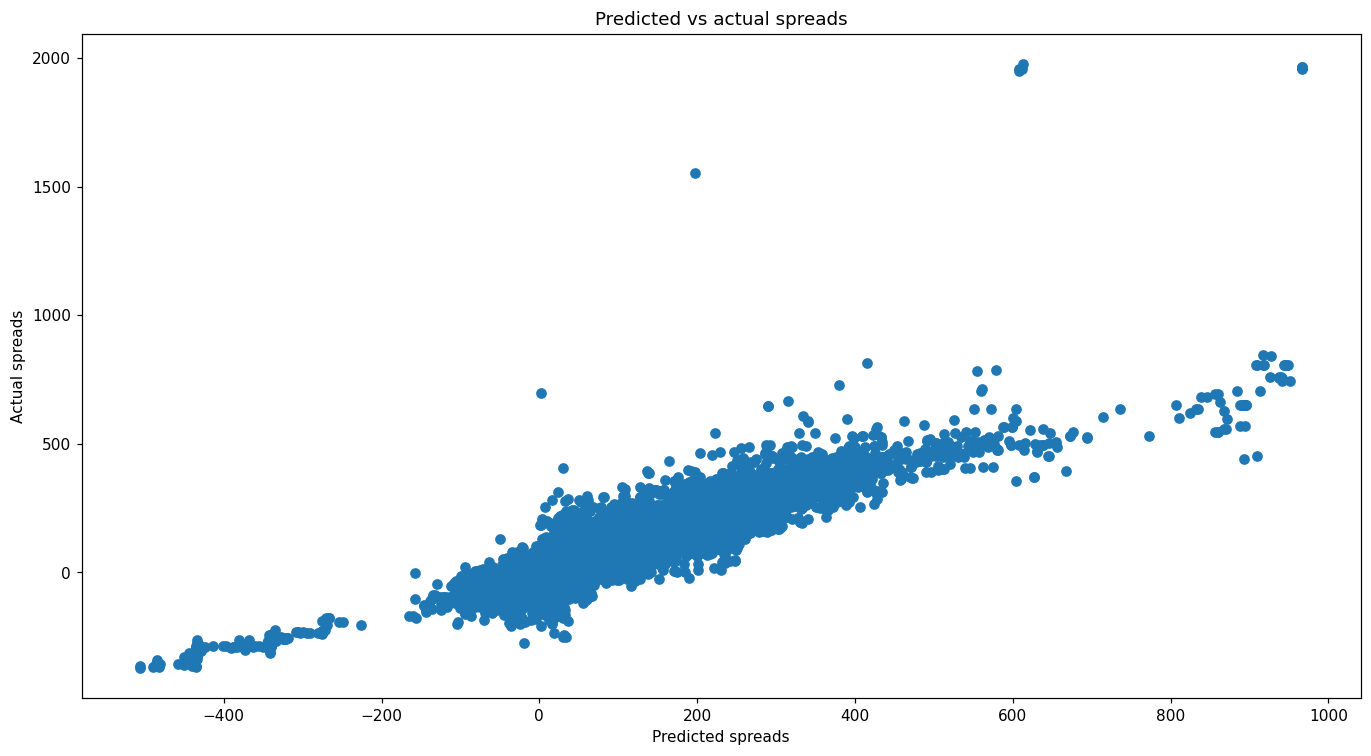

In [84]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.new_ys)

### Baseline using the last yield spread

In [85]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

18.806422260493775


### Baseline using the last yield spread on dealer dealer true mid trades

In [86]:
dd_dataframe = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
dd_last_ys_preds = dd_dataframe.last_yield_spread
error = dd_dataframe.yield_spread - last_ys_preds


MAE = np.mean(np.abs(error))
print(MAE)

# drawpoints(dd_last_ys_preds , dd_dataframe.yield_spread, dd_dataframe)

14.937600778439522


### Regression baseline using previous yield spread optimizing MAE

In [87]:
from statsmodels.regression.quantile_regression import QuantReg

In [88]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [89]:
res = q_reg.fit(q=.5)

In [90]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yield_spread = test_dataframe.yield_spread.values

In [91]:
MAE = np.mean(np.abs(actual_yield_spread - predicted_yield_spread))
print(MAE)

18.746917242388015


In [92]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 0.9907865436780788


In [93]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()

In [94]:
y_mae_regression = res.params[0] * x_range

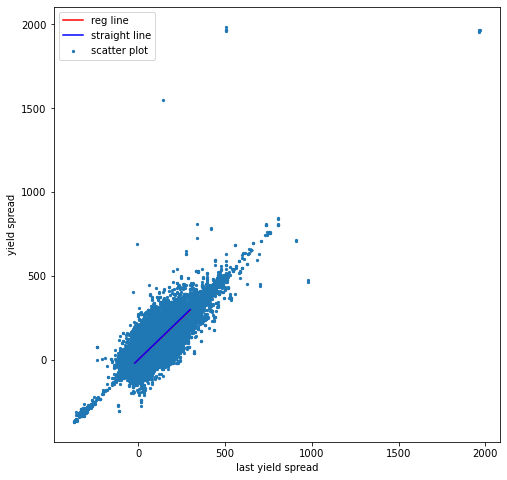

In [95]:
plt.figure(figsize=(8,8))
plt.scatter(test_dataframe.last_yield_spread, actual_yield_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()